In [1]:
import pandas as pd
from pandas import datetime
import datetime
import matplotlib
import numpy as np
import warnings
import itertools
import statsmodels.api as sm
from pandas import Series
from pandas import datetime
from matplotlib import pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
#plt.style.use('fivethirtyeight')
%matplotlib inline
 
production=pd.read_pickle("./processed/production_all_dates_and_variables.pkl")
keep_these=['Wind_KWH',
            'Solar_KWH',
            'Wind_Speed_AT_WINDFARM',
            'Solar_Elevation',
            'Cloud_Cover_Fraction',
            'Dew_Point',
            'Humidity_Fraction',
            'Precipitation',
            'Pressure',
            'Temperature',
            'Visibility',
            'Wind_Speed_AT_SOLARRAY']
production=production[keep_these]
#fill the date and time gaps
production = production.resample("60min").asfreq()
production.to_pickle("./processed/production_full_date_range_pre_impute.pkl")



In [2]:
"""
Implement an imputation scheme for each variable.


Dependent Variables - no imputation
solar - if nighttime, zero
wind - ???
=========================================
'Wind_KWH',
'Solar_KWH',

Dependent Variables - impute as described
CHECK SPARSITY OF VALUES PRIOR TO IMPUTING
=========================================
'Wind_Speed_AT_WINDFARM', - high variance, 
'Solar_Elevation', # Removing, as there is no good way to aggregate this by day, nor is it necessarily relevant except
                     as a performance measure of the solar array, which is not under analysis.
'Cloud_Cover_Fraction', - Average
'Dew_Point', - Average
'Humidity_Fraction', - Average
'Precipitation', - Average
'Pressure', - Average
'Temperature', - Average
'Visibility', - Average
'Wind_Speed_AT_SOLARRAY' - Average

Note: We should do inter-day analysis as well, if possible.

""" 

# Create dataset for seasonality of solar KWH by day.

solar_prod=production['Solar_KWH']
solar_prod_by_day = solar_prod.resample("D").sum().to_frame('Solar_KWH')
solar_prod_by_day.to_pickle("./processed/solar_prod_by_day.pkl")

independent_vars=['Cloud_Cover_Fraction',
                  'Dew_Point',
                  'Humidity_Fraction',
                  'Precipitation',
                  'Pressure',
                  'Temperature',
                  'Visibility',
                  'Wind_Speed_AT_SOLARRAY']

indep_vars=production[independent_vars]
for field in independent_vars:
    # consumption_master = consumption_master.join(calendar, how='outer', sort=True)
    # For each field, aggregate by day, then join to solar_prod
    tmp=pd.DataFrame(data=indep_vars[field])
    tmp.dropna(axis=0, inplace=True)
    tmp=tmp.loc[tmp[field]!='nan'] # How we got text 'nan' in here, I do not know, but remove them.
    tmp=pd.to_numeric(tmp[field], downcast='float')
    # Averaging the remaining values by day should yield a useful metric for modeling, even if
    # it would be meaningless from a real weather-reporting context. 
    # We are imposing the same limitation on all variables, so should still be representative.
    tmp=tmp.resample("D").mean().to_frame(field)
    #print(tmp.head())
    solar_prod_by_day=solar_prod_by_day.join(tmp, how='left', sort=True)
    
#print(solar_prod_by_day.head())


# Now, we need to interpolate missing values.

def interpolate_gaps(values, limit=None):
    """
    Fill gaps using linear interpolation, optionally only fill gaps up to a
    size of `limit`, courtesy of StackOVerflow:
    https://stackoverflow.com/questions/36455083/working-with-nan-values-in-matplotlib
    """
    values = np.asarray(values)
    i = np.arange(values.size)
    valid = np.isfinite(values)
    filled = np.interp(i, i[valid], values[valid])

    if limit is not None:
        invalid = ~valid
        for n in range(1, limit+1):
            invalid[:-n] &= invalid[n:]
        filled[invalid] = np.nan
    return filled


columns={}
dates=solar_prod_by_day.index.values
columns['Date']=dates
for field in list(solar_prod_by_day):
    raw=solar_prod_by_day[field].values
    filled = interpolate_gaps(raw, limit=2)
    columns[field]=filled

solar_prod_by_day_fnl=pd.DataFrame.from_dict(columns)
solar_prod_by_day_fnl.set_index('Date', inplace=True)
solar_prod_by_day_fnl.to_pickle("./processed/solar_prod_by_day_w_interpolation.pkl")


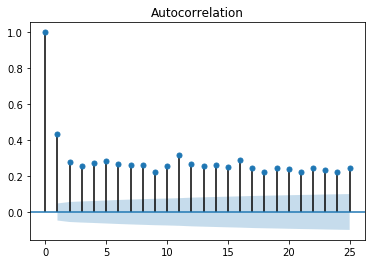

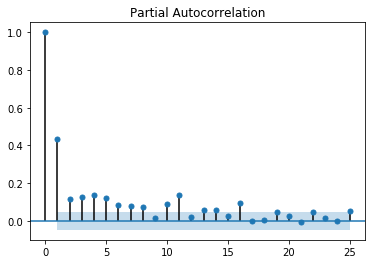

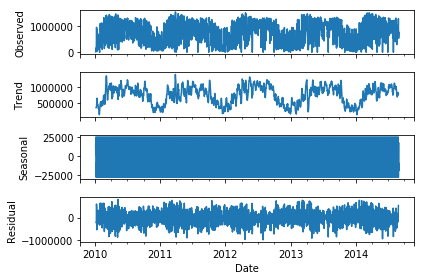

<Figure size 432x288 with 0 Axes>

In [3]:
# Lets do some ARIMA and SARIMA!
# Source Reference: https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
# Excellent resource for explaining ARIMA in general. 
# https://people.duke.edu/~rnau/411arim.htm
# https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

#series=solar_prod_by_day_fnl['Solar_KWH'].loc[solar_prod_by_day_fnl.index.year==2010]
plt.close('all')
series=solar_prod_by_day_fnl['Solar_KWH']

plot_acf(series, lags=25)
plt.show()

plot_pacf(series, lags=25)
plt.show()

# Running the data, we can see that there is a positive correlation with the first 
# ~5 lags that is perhaps significant for the first 2 lags, so AR~=2.

from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(series, model='additive')
result.plot()
fig=plt.figure()
fig.figsize=(12, 15)
plt.show()

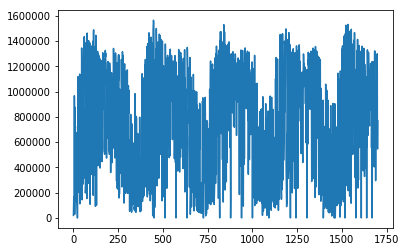

ADF Statistic: -4.417320
p-value: 0.000277
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


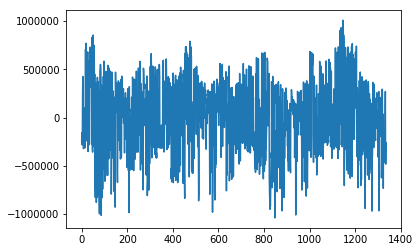

ADF Statistic: -8.807226
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


In [4]:
# Adapted from: 'Time Series Forecasting With Python' by Jason Brownlee
from statsmodels.tsa.stattools import adfuller
series=solar_prod_by_day_fnl['Solar_KWH']
X=series.values
diff=list()
records=[]

plt.plot(X)
plt.show()

# check if original series is stationary
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
days_in_year = 365
for i in range(days_in_year, len(X)):
    month_str = str(series.index[i].year-1)+ ' - ' +str(series.index[i].month)
    month_mean_last_year = series[month_str].mean()
    value = X[i] - month_mean_last_year
    diff.append(value)
    records.append([series.index[i], X[i], value])
new_df=pd.DataFrame(records, columns=['Date', 'Solar_KWH', 'Adj_Solar_KWH'])
new_df.set_index('Date', inplace=True)

plt.plot(diff)
plt.show()

# check if adjusted series is stationary
result = adfuller(diff)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))



In [5]:
#plot residual errors
best_aic, best_param, best_model = get_best_model(diff)
print("Final best parameter: {} and minimal AIC: {}".format(best_param, best_aic))
residuals = pd.DataFrame(best_model.resid)
residuals.plot(figsize=(15, 12))
plt.show()
residuals.plot(kind='kde',figsize=(15, 12))
plt.show()
print(residuals.describe())


NameError: name 'get_best_model' is not defined

In [ ]:
imgname="ARIMA_param_{}_aic_{}".format(best_param, int(round(best_aic,0)))
print(imgname)
#results.plot_diagnostics(figsize=(15, 12)).savefig("./Images/" + imgname + '.png')

In [ ]:
plot_acf(diff, lags=25)
plt.show()

plot_pacf(diff, lags=25)
plt.show()

In [ ]:
num_bins=10
pop=abs(min(diff)) + abs(max(diff))
interval=int(round(pop/num_bins, 0))

bins = np.arange(min(diff), max(diff), interval)

plt.xlim([min(diff)-5, max(diff)+5])

plt.hist(diff, bins=bins, alpha=0.5)
plt.title('Seasonally Adjusted Solar_KWH data (fixed bin size)')
plt.xlabel('variable X (# bins = {})'.format(num_bins))
plt.ylabel('count')

plt.show()

In [ ]:
num_bins=10
pop=abs(min(series)) + abs(max(series))
interval=int(round(pop/num_bins, 0))

bins = np.arange(min(series), max(series), interval)

plt.xlim([min(series)-5, max(series)+5])

plt.hist(series, bins=bins, alpha=0.5)
plt.title('Non-Seasonally Adjusted Solar_KWH data (fixed bin size)')
plt.xlabel('variable X (# bins = {})'.format(num_bins))
plt.ylabel('count')

plt.show()

In [ ]:
# From: 
# https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3
# Significantly adapted, but the iterative approach and some code is a direct-use.

def find_best_sarima_model(train_years, test_years, df, endogenous_variable):
    train_data=df[endogenous_variable].loc[(df.index.year.isin(train_years))]
    train=train_data.values

    test_data=df[endogenous_variable].loc[(df.index.year.isin(test_years))]
    test=test_data.values

    # Define the p, d and q parameters to take any value between 0 and 2
    p = d = q = range(0, 3)

    # Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))

    # Generate all different combinations of seasonal p, q and q triplets
    # Since we are daily data, m=360, suggesting a yearly cycle.
    seasonal_pdq = [(x[0], x[1], x[2], 360) for x in list(itertools.product(p, d, q))]
    
    warnings.filterwarnings("ignore") # specify to ignore warning messages
    count=1
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(train,
                                                #exog=exog,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                if count==1:
                    tmp_best=results.aic
                    count+=1
                else:
                    if tmp_best > results.aic:
                        tmp_best=results.aic
                        tmp_best_param=param
                        tmp_best_seasonal=param_seasonal
                        tmp_best_model=results
                        count+=1
                    else:
                        count+=1
                    
                print('ARIMA{}x{} - AIC:{} - best AIC: {} - Iteration: {}'.format(param,
                                                                                    param_seasonal,
                                                                                    results.aic,
                                                                                    tmp_best,
                                                                                    count))
            
            except Exception as e:
                print('Exception: {} ARIMA{}x{} - Iteration: {}'.format(e,
                                                                          param,
                                                                          param_seasonal,
                                                                          count))
                continue
                
    return(tmp_best, tmp_best_param, tmp_best_seasonal, tmp_best_model)


In [ ]:

def find_best_arima_model(series):
    # Define the p, d and q parameters to take any value between 0 and 2
    p = d = q = range(0, 3)

    # Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))

    # Generate all different combinations of seasonal p, q and q triplets
    # Since we are daily data, m=360, suggesting a yearly cycle.
    seasonal_pdq = [(x[0], x[1], x[2]) for x in list(itertools.product(p, d, q))]
    
    warnings.filterwarnings("ignore") # specify to ignore warning messages
    count=1
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                model = ARIMA(series, order=(param_seasonal))
                model_fit = model.fit(disp=0)
                aic=model_fit.aic
                if count == 1:
                    best_aic=aic
                    best_param=param_seasonal
                    count += 1
                else:
                    if aic < best_aic:
                        best_aic=aic
                        best_param=param_seasonal
                        best_model=model_fit
                        print("New better parameter: {} and AIC: {}".format(best_param, best_aic))
            except:
                #print(e)
                pass
    return best_aic, best_param, best_model
        


In [ ]:
# Lets split the data into 3 years train, one test, across years. Assumption: That any long-
# term weather trend will not manifest materially within a three year timeframe.

years=[2010, 2011, 2012, 2013]

#for scenario in scenarios:
for iteration in range(0, len(years)):
    list_len=len(years)
    train_years=years[1:len(years)]
    test_year=[]
    test_year.append(years[0])
    print("Iteration: {} Test: {} Train: {}".format(iteration, test_year, train_years))
    tmp_best_aic, tmp_best_param, tmp_best_model = find_best_arima_model(new_df['Adj_Solar_KWH'].loc[new_df.index.year.isin(train_years)])
    # fit_predict test, report results.

    print("Best param: {} Best AIC: {} Best Model: \n{}".format(tmp_best_param,
                                                                tmp_best_aic,
                                                                tmp_best_model.summary()))
   
    
    years.append(years.pop(0))

In [ ]:
# From: https://machinelearningmastery.com/time-series-forecast-study-python-monthly-sales-french-champagne/
from pandas import Series
from sklearn.metrics import mean_squared_error
from math import sqrt
# load data
#series=new_df['Adj_Solar_KWH']

series=production['Solar_KWH'].fillna(0)
#solar_prod_by_hour = solar_prod.resample("D").sum().to_frame('Solar_KWH')


#series=solar_prod_by_day_fnl['Solar_KWH']
#series=solar_prod_by_day_fnl['Solar_KWH'].resample('M').mean()
#series=new_df['Adj_Solar_KWH'].resample('D').sum()
#series=new_df['Solar_KWH'].resample('D').sum()
#series=new_df['Solar_KWH'].resample('W').mean()
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.75)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # predict
    yhat = history[-1]
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
#    print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)
print(solar_prod_by_day_fnl['Solar_KWH'].describe())
print(solar_prod_by_day_fnl['Solar_KWH'].var())

In [ ]:
from pandas import Series
from statsmodels.tsa.stattools import adfuller
from matplotlib import pyplot
 
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
 
series=solar_prod_by_day_fnl['Solar_KWH']
#series = Series.from_csv('dataset.csv')
X = series.values
X = X.astype('float32')
# difference data
months_in_year = 12
stationary = difference(X, months_in_year)
stationary.index = series.index[months_in_year:]
# check if stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
# save
#stationary.to_csv('stationary.csv')
# plot
stationary.plot()
pyplot.show()

In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd

#years=[2010, 2011, 2012, 2013]
#dta = sm.datasets.sunspots.load_pandas().data[['SUNACTIVITY']]
#dta.index = pd.DatetimeIndex(start='1700', end='2009', freq='A')
dta=new_df['Adj_Solar_KWH']
res = sm.tsa.ARIMA(dta, (1, 1, 1)).fit()
fig, ax = plt.subplots()
ax = dta.loc['2010':].plot(ax=ax)
fig = res.plot_predict('2013',
                       '2014',
                       dynamic=True,
                       ax=ax,
                       plot_insample=False)
plt.show()

In [8]:
from sklearn.metrics import mean_squared_error, r2_score
#series=production['Solar_KWH'].fillna(0)
#solar_prod_by_hour = solar_prod.resample("D").sum().to_frame('Solar_KWH')


#series=solar_prod_by_day_fnl['Solar_KWH']
series=solar_prod_by_day_fnl['Solar_KWH'].resample('M').mean()
#series=new_df['Adj_Solar_KWH'].resample('D').sum()
#series=new_df['Solar_KWH'].resample('D').sum()
#series=new_df['Solar_KWH'].resample('W').mean()

# Create lagged dataset
values = pd.DataFrame(series.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
print(dataframe.head(5))

X = dataframe.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]


# persistence model
def model_persistence(x):
    return x

predictions = list()
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)
test_score = mean_squared_error(test_y, predictions)**.5
#print('Test MSE: %.3f' % test_score)
print("Baseline RMSE: {:,}".format(test_score))
print('Baseline R^2: {:,}'.format(r2_score(test_y, predictions)))

            t-1           t+1
0           NaN  3.702621e+05
1  3.702621e+05  5.234830e+05
2  5.234830e+05  1.013155e+06
3  1.013155e+06  9.127493e+05
4  9.127493e+05  9.273341e+05
Baseline RMSE: 162,722.01160592324
Baseline R^2: 0.5132163464497757
